# Introduction to Brian part 3: Simulations

*Modified by Kai Chen*

**Reference:** https://brian2.readthedocs.io/en/stable/

This tutorial is about managing the slightly more complicated tasks that crop up in research problems, rather than the toy examples we've been looking at so far. So we cover things like inputting sensory data, modelling experimental conditions, etc.

In [1]:
import matplotlib.pyplot as plt
plt.style.use("https://raw.githubusercontent.com/NeoNeuron/professional-workshop-3/master/nma.mplstyle")
from brian2 import *

## Multiple runs

Let's start by looking at a very common task: doing multiple runs of a simulation with some parameter that changes. Let's start off with something very simple, how does the firing rate of a leaky integrate-and-fire neuron driven by Poisson spiking neurons change depending on its membrane time constant? Let's set that up.

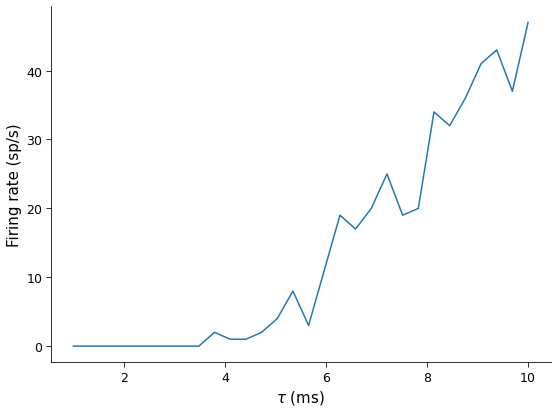

In [2]:
# remember, this is here for running separate simulations in the same notebook
start_scope() 
# Parameters
num_inputs = 100
input_rate = 10*Hz
weight = 0.1
# Range of time constants
tau_range = linspace(1, 10, 30)*ms
# Use this list to store output rates
output_rates = []
# Iterate over range of time constants
for tau in tau_range:
    # Construct the network each time
    P = PoissonGroup(num_inputs, rates=input_rate)
    eqs = '''
    dv/dt = -v/tau : 1
    '''
    G = NeuronGroup(1, eqs, threshold='v>1', reset='v=0', method='exact')
    S = Synapses(P, G, on_pre='v += weight')
    S.connect()
    M = SpikeMonitor(G)
    # Run it and store the output firing rate in the list
    run(1*second)
    output_rates.append(M.num_spikes/second)
# And plot it
plot(tau_range/ms, output_rates)
xlabel(r'$\tau$ (ms)')
ylabel('Firing rate (sp/s)');

Now if you're running the notebook, you'll see that this was a little slow to run. The reason is that for each loop, you're recreating the objects from scratch. We can improve that by setting up the network just once. We store a copy of the state of the network before the loop, and restore it at the beginning of each iteration.

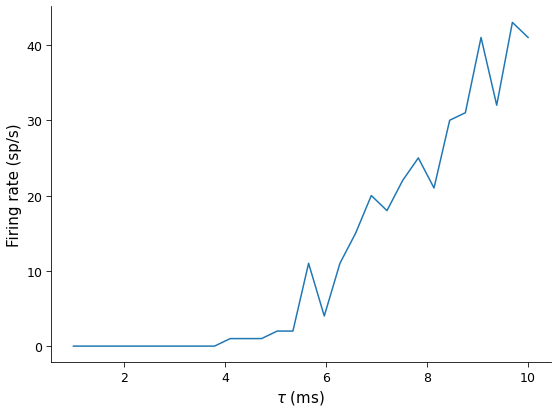

In [3]:
start_scope() 
num_inputs = 100
input_rate = 10*Hz
weight = 0.1
tau_range = linspace(1, 10, 30)*ms
output_rates = []
# Construct the network just once
P = PoissonGroup(num_inputs, rates=input_rate)
eqs = '''
dv/dt = -v/tau : 1
'''
G = NeuronGroup(1, eqs, threshold='v>1', reset='v=0', method='exact')
S = Synapses(P, G, on_pre='v += weight')
S.connect()
M = SpikeMonitor(G)
# Store the current state of the network
store()
for tau in tau_range:
    # Restore the original state of the network
    restore()
    # Run it with the new value of tau
    run(1*second)
    output_rates.append(M.num_spikes/second)
plot(tau_range/ms, output_rates)
xlabel(r'$\tau$ (ms)')
ylabel('Firing rate (sp/s)');

That's a very simple example of using store and restore, but you can use it in much more complicated situations. For example, you might want to run a long training run, and then run multiple test runs afterwards. Simply put a store after the long training run, and a restore before each testing run.

You can also see that the output curve is very noisy and doesn't increase monotonically like we'd expect. The noise is coming from the fact that we run the Poisson group afresh each time. If we only wanted to see the effect of the time constant, we could make sure that the spikes were the same each time (although note that really, you ought to do multiple runs and take an average). We do this by running just the Poisson group once, recording its spikes, and then creating a new `SpikeGeneratorGroup` that will output those recorded spikes each time.

## Changing things during a run

Imagine an experiment where you inject current into a neuron, and change the amplitude randomly every 10 ms. Let's see if we can model that using a Hodgkin-Huxley type neuron.

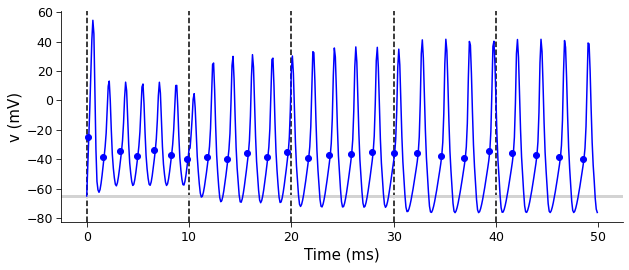

In [4]:
start_scope()
# Parameters
area = 20000*umetre**2
Cm = 1*ufarad*cm**-2 * area
gl = 5e-5*siemens*cm**-2 * area
El = -65*mV
EK = -90*mV
ENa = 50*mV
g_na = 100*msiemens*cm**-2 * area
g_kd = 30*msiemens*cm**-2 * area
VT = -63*mV
# The model
eqs_HH = '''
dv/dt = (gl*(El-v) - g_na*(m*m*m)*h*(v-ENa) - g_kd*(n*n*n*n)*(v-EK) + I)/Cm : volt
dm/dt = 0.32*(mV**-1)*(13.*mV-v+VT)/
    (exp((13.*mV-v+VT)/(4.*mV))-1.)/ms*(1-m)-0.28*(mV**-1)*(v-VT-40.*mV)/
    (exp((v-VT-40.*mV)/(5.*mV))-1.)/ms*m : 1
dn/dt = 0.032*(mV**-1)*(15.*mV-v+VT)/
    (exp((15.*mV-v+VT)/(5.*mV))-1.)/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms*h : 1
I : amp
'''
group = NeuronGroup(1, eqs_HH,
                    threshold='v > -40*mV',
                    refractory='v > -40*mV',
                    method='exponential_euler')
group.v = El
statemon = StateMonitor(group, 'v', record=True)
spikemon = SpikeMonitor(group, variables='v')
figure(figsize=(9, 4))
for l in range(5):
    group.I = rand()*50*nA
    run(10*ms)
    axvline(l*10, ls='--', c='k')
axhline(El/mV, ls='-', c='lightgray', lw=3)
plot(statemon.t/ms, statemon.v[0]/mV, '-b')
plot(spikemon.t/ms, spikemon.v/mV, 'ob')
xlabel('Time (ms)')
ylabel('v (mV)');

## Adding input

Now let's think about a neuron being driven by a sinusoidal input. Let's go back to a leaky integrate-and-fire to simplify the equations a bit.

Now, what if that input current were something we had recorded and saved in a file? In that case, we can use `TimedArray`. Let's start by reproducing the picture above but using `TimedArray`.

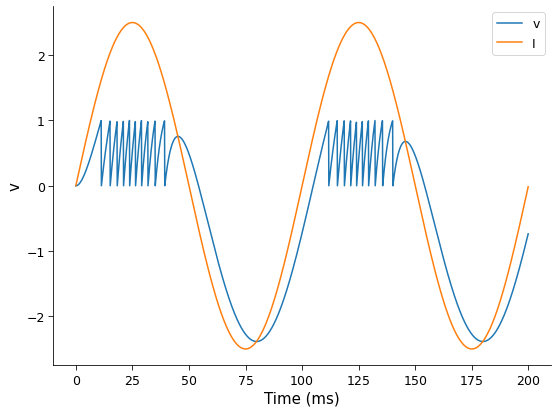

In [5]:
start_scope()
A = 2.5
f = 10*Hz
tau = 5*ms
# Create a TimedArray and set the equations to use it
t_recorded = arange(int(200*ms/defaultclock.dt))*defaultclock.dt
I_recorded = TimedArray(A*sin(2*pi*f*t_recorded), dt=defaultclock.dt)
eqs = '''
dv/dt = (I-v)/tau : 1
I = I_recorded(t) : 1
'''
G = NeuronGroup(1, eqs, threshold='v>1', reset='v=0', method='exact')
M = StateMonitor(G, variables=True, record=True)
run(200*ms)
plot(M.t/ms, M.v[0], label='v')
plot(M.t/ms, M.I[0], label='I')
xlabel('Time (ms)')
ylabel('v')
legend(loc='best');

Note that for the example where we put the ``sin`` function directly in the equations, we had to use the ``method='euler'`` argument because the exact integrator wouldn't work here (try it!). However, ``TimedArray`` is considered to be constant over its time step and so the linear integrator can be used. This means you won't get the same behaviour from these two methods for two reasons. Firstly, the numerical integration methods ``exact`` and ``euler`` give slightly different results. Secondly, ``sin`` is not constant over a timestep whereas ``TimedArray`` is.

Now just to show that ``TimedArray`` works for arbitrary currents, let's make a weird "recorded" current and run it on that.

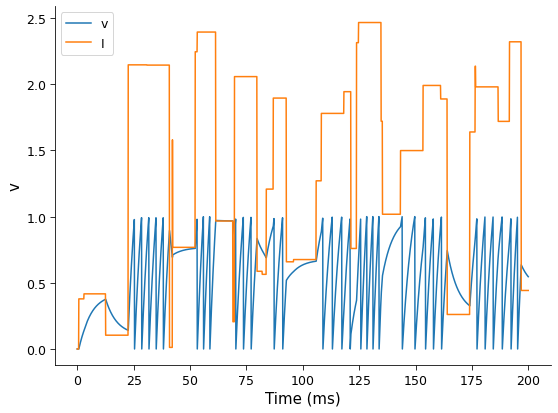

In [6]:
start_scope()
A = 2.5
f = 10*Hz
tau = 5*ms
# Let's create an array that couldn't be
# reproduced with a formula
num_samples = int(200*ms/defaultclock.dt)
I_arr = zeros(num_samples)
for _ in range(100):
    a = randint(num_samples)
    I_arr[a:a+100] = rand()
I_recorded = TimedArray(A*I_arr, dt=defaultclock.dt)
eqs = '''
dv/dt = (I-v)/tau : 1
I = I_recorded(t) : 1
'''
G = NeuronGroup(1, eqs, threshold='v>1', reset='v=0', method='exact')
M = StateMonitor(G, variables=True, record=True)
run(200*ms)
plot(M.t/ms, M.v[0], label='v')
plot(M.t/ms, M.I[0], label='I')
xlabel('Time (ms)')
ylabel('v')
legend(loc='best');